In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier 

# The Challenge

The goal of this algorithm is to interpret historical accident data and predict the severity of accidents that may occur in the area based on the attributes that are heavily correlated. This information can be used to suggest avoiding areas during route planning and could allow the insurance company to make preliminary estimates based on the accident location

## Data Visualization

Reads in accident data then processes it to produce a bar graph measuring accidents by state. This would allow the analyzer to visualize the data to see the amount of accidents that occur in each state, compared to other states.

Text(0, 0.5, 'Number of accidents')

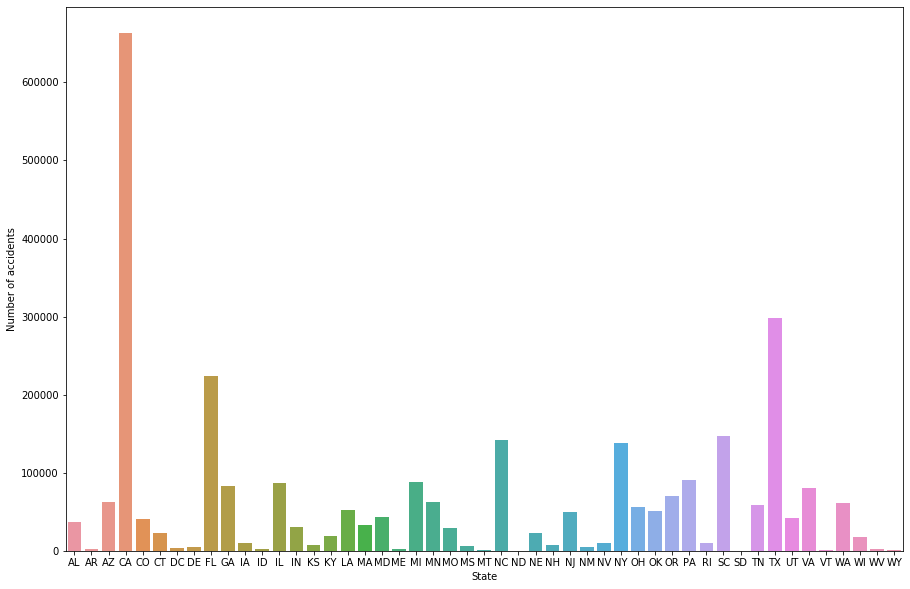

In [2]:
path = os.getcwd()
data_df = pd.read_csv((path+'/Static/US_Accidents_Dec19.csv'),index_col=False)
data_df = data_df.drop(columns = ['Start_Lat','Start_Lng','End_Lat','End_Lng','Source','TMC'])
#df = data_df.drop(['ID'],axis = 1)
data_df.head(5)
[row,col] = data_df.shape
state_count = ((data_df.groupby('State').count())['ID'])
plt.figure(figsize=(15,10))
ax = sns.barplot(state_count.index, state_count.values)
plt.ylabel('Number of accidents')

California and Texas are states with the most number of accidents. Since Texas and California are the most populous states, because of the number of people drives in these states is also the highest. 

Text(0, 0.5, 'Percentage of accidents')

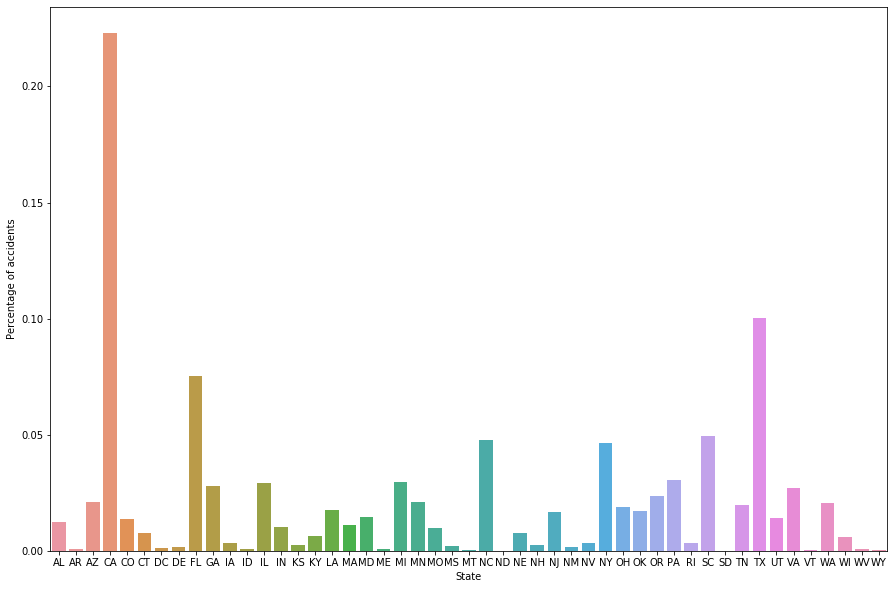

In [3]:
#df = data_df.drop(['ID'],axis = 1)
data_df.head(5)
[row,col] = data_df.shape
state_count = ((data_df.groupby('State').count())['ID'])
plt.figure(figsize=(15,10))
ax = sns.barplot(state_count.index, state_count.values/row)
plt.ylabel('Percentage of accidents')

Over 20% of all accident in the United States occurs in the state of California, and over 10% of accidents occur in Texas. 

Text(0, 0.5, 'Ratio of accident to number of people')

<Figure size 1080x720 with 0 Axes>

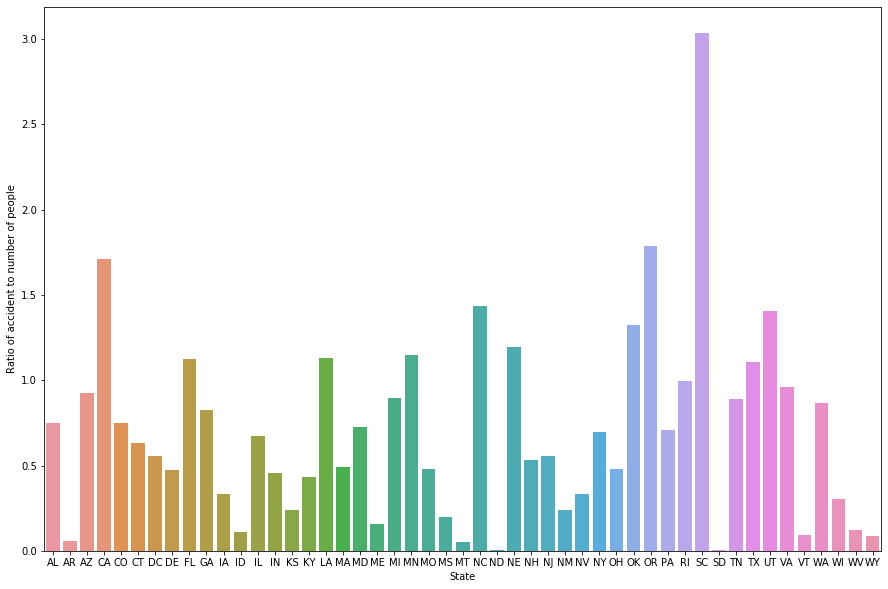

In [4]:
state_population_df = pd.read_csv((path+'/Static/state_population_copy.csv'),index_col= 'Postal')
plt.figure(figsize=(15,10))
state_population = state_population_df.drop(index = ['AR','IA'])
state_population_df = state_population_df.sort_values(by = 'Postal')
state_population_df['count'] = state_count
plt.figure(figsize=(15,10))
state_population_df = state_population_df.dropna()
state_population_df.head()
ax = sns.barplot(state_count.index, 
                 100*state_population_df['count']/state_population_df['Population'])
plt.ylabel('Ratio of accident to number of people')

In [5]:
old_series = state_population_df['count']/state_population_df['Population']
new_series = pd.Series(state_count.values/row, index = state_count.index )
new_series = new_series.drop(index = ['AR','IA'])
new_df = pd.concat([new_series,old_series],axis = 1,sort= True)
new_df.columns = ['percentage','average']
new_df = new_df.dropna()
#new_df.to_csv('Number of accidents.csv')

To get a better understanding of the frequency of accidents relative to population (weight), we divide the number of accidents by population. This shows that South Dakota has the worst number of accidents compared to their population.

In [ ]:
plt.figure(figsize=(15,10))
test = (pd.to_datetime(data_df['End_Time']) - pd.to_datetime(data_df['Start_Time']))/np.timedelta64(1,'m')
sns.scatterplot(x = data_df.index,y = test , hue = data_df['Severity'])
plt.xlabel('Id')
plt.ylabel('Duration')
plt.title('Accident times')

Text(0.5, 1.0, 'Accident times')

The figure displays the time during each accident in the data set.  As one can see, the majority of accident duration is less than 100 minutes and of low severity. 

# Pre-proccessing
In order to further understand which attributes effect the severity of an accident the most, we process the data to find the attributes with the strongest correlation. This leaves us with fators that actually play a part in accident severity.

In [7]:
cols = ('Street','Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight')
new_data_df = data_df.drop(columns = ['End_Time','Start_Time'])
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(new_data_df[c].values)) 
    new_data_df[c] = lbl.transform(list(new_data_df[c].values))

In [8]:
incode = LabelEncoder()
new_data_df['Weather_Condition'] = incode.fit_transform(list(new_data_df['Weather_Condition'].values))

To determine the which attributes effect severity, we encode all categorical attributes and calculate the corralation rates.

In [10]:
coor_value = ((new_data_df.corr()['Severity']).abs())
coor_value.sort_values()

Roundabout               0.003843
Bump                     0.005455
Visibility(mi)           0.006136
No_Exit                  0.006709
Traffic_Calming          0.006786
Airport_Code             0.007700
Give_Way                 0.007847
City                     0.008162
Timezone                 0.013703
Precipitation(in)        0.016632
Pressure(in)             0.018289
Humidity(%)              0.023188
Railway                  0.023666
Number                   0.023979
Temperature(F)           0.029132
Wind_Speed(mph)          0.030343
Weather_Condition        0.035218
State                    0.037516
Amenity                  0.049221
Station                  0.052094
Stop                     0.055394
Zipcode                  0.057871
Weather_Timestamp        0.058940
Junction                 0.063437
Sunrise_Sunset           0.068988
County                   0.074298
Civil_Twilight           0.076560
Wind_Chill(F)            0.079993
Nautical_Twilight        0.083870
Astronomical_T

In [13]:
X_data = data_df[(['Crossing','Side', 'Wind_Chill(F)','Astronomical_Twilight','Traffic_Signal','Severity']) ]
X_data = X_data.dropna()
y_label = X_data['Severity']
X_data = X_data.drop(columns = 'Severity',axis = 1)

# Feature selection
Using the information gained from the the correlation, between the different features and sevarity of the accident. 

In [14]:
cols = ('Crossing','Side','Astronomical_Twilight','Traffic_Signal')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(X_data[c].values)) 
    X_data[c] = lbl.transform(list(X_data[c].values))
X_data = X_data.dropna()
X_train, X_Valid, Y_train, Y_Valid=train_test_split(X_data,y_label, test_size=0.15, random_state=4)

# Model Exploration
Create training and actual sets by splitting the given data to create the model that will be used to predict severity. Assessing the perfromance of different model, and hyperparameters. 

In [15]:
model_rf = RandomForestClassifier(n_estimators = 100)
model_rf.fit(X_train,Y_train)
prediction = model_rf.predict(X_Valid)
rf_accuracy = metrics.accuracy_score(prediction, Y_Valid)
print('Random_Forest acc:', rf_accuracy)

Random_Forest acc: 0.6985789257843842


We assess the performance of the AdaBoost Classifier and restrict the number of estimators to increase training time.

In [16]:
model_ada = AdaBoostClassifier(n_estimators= 100)
model_ada.fit(X_train,Y_train)
prediction = model_ada.predict(X_Valid)
ada_accuracy = metrics.accuracy_score(prediction, Y_Valid)
print('Random_Forest acc:', ada_accuracy)

Random_Forest acc: 0.6982936411237838


Train the two model on all of the data, and saving the model to be used in the web application for determining the safety of a route.

In [19]:
# Random Forest Model
model_rf = RandomForestClassifier(n_estimators = 100)
model_rf.fit(X_data,y_label)
pkl_filename = "random_forest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_rf, file)
# The AdaBoost Model
model_ada = AdaBoostClassifier(n_estimators= 100)
model_ada.fit(X_data,y_label)
pkl_filename = "ada_boost.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_rf, file)

Creating a final CSV which will be uploaded to google's autoML platform, and used to train a neural network.

In [20]:
final_data = X_train
final_data['label'] = y_label
final_data= final_data.reset_index(drop = True)

/Users/abhay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
final_data.head()
final_data.to_csv((path+'Final_data.csv'))

##### Exporting all model data to a .csv file

### Conclusion
Upon finishing our data analysis and processing, we found that both the RandomForest model and the AdaBoost model performed well, with neither being superior. We also ran the model on the google autoML cloud platform, which gave similar results. In our journey, we found only 5 out of 49 features leased in the Dataset provide insight into the severity of the accident. Information leads to confidence and trust, and drivers all around us need trust that their lives are safe. 